# Nearest Neighbour Analysis


One commonly used GIS task is to be able to find the nearest neighbour for an object or a set of objects. For instance, you might have a single Point object
representing your home location, and then another set of locations representing e.g. public transport stops. Then, quite typical question is *"which of the stops is closest one to my home?"*
This is a typical nearest neighbour analysis, where the aim is to find the closest geometry to another geometry.

In Python this kind of analysis can be done with shapely function called ``nearest_points(geom1, geom2)`` that [returns a tuple (origin, nearest_destination) of the nearest points in the input geometries](https://shapely.readthedocs.io/en/latest/manual.html#shapely.ops.nearest_points).

## Nearest point using Shapely


Let's start by testing how we can find the nearest Point using the ``nearest_points()`` function of Shapely.

- Let's create an origin Point and a few destination Points and find out the closest destination:




In [1]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Origin point
orig = Point(1, 1.67)

# Destination points
dest1 = Point(0, 1.45)
dest2 =Point(2, 2)
dest3 = Point(0, 2.5)

To be able to find out the closest destination point from the origin, we need to create a MultiPoint object from the destination points.

In [27]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


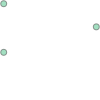

In [3]:
destinations

Okey, now we can see that all the destination points are represented as a single MultiPoint object.

- Now we can find out the nearest destination point by using ``nearest_points()`` function:


In [28]:
nearest_geoms = nearest_points(orig, destinations) # returns a tuple containing the origin point and the nearest detination point

- We can check the data type of this object and confirm that the ``nearest_points()`` function returns a tuple of nearest points:

In [5]:
type(nearest_geoms)

tuple

__let's check the contents of this tuple:__
 - the tuple contains origin point and the nearest detination point

In [76]:
# Let's print the nearest (detination) point: 
print(f'Origin: {nearest_geoms[0]}, \nDestination: {nearest_geoms[1]}')

Origin: POINT (1 1.67), 
Destination: POINT (0 1.45)


## Nearest points using Geopandas

Let's then see how it is possible to find nearest points from a set of origin points to a set of destination points using GeoDataFrames. Here, we will use the ``PKS_suuralueet.kml`` district data, and the ``addresses.shp`` address points from previous sections. 



**Our goal in this tutorial is to find out the closest address to the centroid of each district.**

- Let's first read in the data and check their structure:

In [29]:
# Import geopandas
import geopandas as gpd

In [30]:
# Define filepaths
fp1 = "data/PKS_suuralue.kml"
fp2 = "data/addresses.shp"

In [31]:
# Enable KML driver
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [48]:
# Read in data with geopandas
df1 = gpd.read_file(fp1, driver='KML')
df2 = gpd.read_file(fp2)

In [49]:
# District polygons:
df1.head()

,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."


In [35]:
# Address points:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


- Furthermore, let's calculate the centroids for each district area:

In [90]:
df1['centroid'] = df1.centroid
df1.head()

C:\Users\gcolm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766...",POINT (24.76754 60.04409),1000
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155...",POINT (24.57415 60.19764),1020
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752...",POINT (24.60401 60.25253),1020
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699...",POINT (24.68683 60.30649),1017
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537...",POINT (24.76064 60.15018),1020


SO, for each row of data in the disctricts -table, we want to figure out the nearest address point and fetch some attributes related to that point. In other words, we want to apply the Shapely `nearest_points`function so that we compare each polygon centroid to all address points, and based on this information access correct attribute information from the address table. 

For doing this, we can create a function that we will apply on the polygon GeoDataFrame:

In [80]:
def get_nearest_values2(row, other_gdf, point_column='geometry', value_column="geometry"):
    """Find the nearest point and return the corresponding value from specified value column."""

    # Create an union of the other GeoDataFrame's geometries:
    other_points = other_gdf["geometry"].unary_union

    # Find the nearest points
    nearest_geoms = nearest_points(row[point_column], other_points)

    # Get corresponding values from the other df
    nearest_data = other_gdf.loc[other_gdf["geometry"] == nearest_geoms[1]]

    nearest_value = nearest_data[value_column].values[0]

    return nearest_value

By default, this function returns the geometry of the nearest point for each row. It is also possible to fetch information from other columns by changing the `value_column` parameter.

In [85]:
df1["nearest_loc"] = df1.apply(get_nearest_values2, other_gdf=df2, point_column="centroid", axis=1)
df1.head()

,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766...",POINT (24.76754 60.04409),POINT (24.9155624 60.1632015)
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155...",POINT (24.57415 60.19764),POINT (24.8608434 60.2240225)
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752...",POINT (24.60401 60.25253),POINT (24.8608434 60.2240225)
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699...",POINT (24.68683 60.30649),POINT (24.866902 60.2517147)
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537...",POINT (24.76064 60.15018),POINT (24.8608434 60.2240225)


The function creates a MultiPoint object from `other_gdf` geometry column (in our case, the address points) and further passes this MultiPoint object to Shapely's `nearest_points` function. 

Here, we are using a method for creating an union of all input geometries called `unary_union`. 

- Let's check how unary union works by applying it to the address points GeoDataFrame:

In [38]:
# print Address dataframe
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


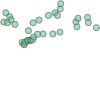

In [40]:
# print dataframe geometry column applying 'unary_union'
df2.geometry.unary_union

In [24]:
unary_union = df2.unary_union
print(unary_union)

MULTIPOINT (24.8608434 60.2240225, 24.86128 60.2484905, 24.8710287 60.222498, 24.8769977 60.2397435, 24.8842071 60.2305, 24.8941806817097 60.21721545, 24.9155624 60.1632015, 24.9212065 60.1587845, 24.9216003 60.1566475, 24.9252037 60.1648863, 24.9316914 60.1690222, 24.9331155798105 60.1690911, 24.9338755 60.1995271, 24.9416849 60.1699637, 24.9422931 60.1711382, 24.9470863 60.1719054, 24.9480051 60.2217879, 24.9495338 60.1794339, 24.961156 60.1879465, 24.9656577 60.2298169, 24.9719335 60.1969965, 24.9936217 60.2436491, 25.0068082 60.1887169, 25.0130341 60.2513441, 25.0204879 60.243423, 25.026632061488 60.1944775, 25.0291169 60.2636285, 25.0331561080774 60.2777903, 25.0747841 60.2253109, 25.0783462 60.209819, 25.0817387723606 60.23521665, 25.1069663 60.2391463, 25.1109579 60.2216552, 25.1368632 60.2070291)


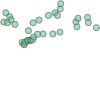

In [20]:
df2['geometry'].unary_union

Okey now we are ready to use our function and find closest address point for each polygon centroid.
 - Try first applying the function without any additional modifications: 

In [41]:
df1.head()

,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766...",POINT (24.76754 60.04409)
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155...",POINT (24.57415 60.19764)
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752...",POINT (24.60401 60.25253)
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699...",POINT (24.68683 60.30649)
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537...",POINT (24.76064 60.15018)


In [53]:
df2.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97783 60.18892)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


In [86]:
df1.apply(get_nearest_values, other_gdf=df2, point_column='centroid', value_column="geometry", axis=1)

0             POINT (24.9155624 60.1632015)
1             POINT (24.8608434 60.2240225)
2             POINT (24.8608434 60.2240225)
3              POINT (24.866902 60.2517147)
4             POINT (24.8608434 60.2240225)
5             POINT (24.8608434 60.2240225)
6             POINT (24.8608434 60.2240225)
7             POINT (24.8608434 60.2240225)
8              POINT (24.866902 60.2517147)
9              POINT (24.866902 60.2517147)
10            POINT (24.9216003 60.1566475)
11            POINT (25.0068082 60.1887169)
12            POINT (24.9614167 60.1877945)
13    POINT (24.87197203547472 60.22243925)
14            POINT (24.9480051 60.2217879)
15            POINT (25.0206319 60.2435543)
16            POINT (24.9656577 60.2298169)
17            POINT (25.0300817 60.2785562)
18            POINT (25.0300817 60.2785562)
19            POINT (25.1357989 60.2072005)
20            POINT (25.1357989 60.2072005)
21            POINT (25.1097946 60.2378517)
22            POINT (25.0300817 

In [87]:
""" When applying function to dataframes, we provide the function name and its parameter, 
    then remove the row parameter, because the apply() function will iterate over the dataframe, applying 
    the function 'get_nearest_values' to each row of the dataframe."""

df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", value_column='geometry', axis=1)

- Finally, we can specify that we want the `id` -column for each point, and store the output in a new column `"nearest_loc"`:

In [88]:
df1["nearest_loc"] = df1.apply(get_nearest_values, other_gdf=df2, point_column="centroid", value_column="id", axis=1)

In [89]:
df1.head()

,Name,Description,geometry,centroid,nearest_loc
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766...",POINT (24.76754 60.04409),1000
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155...",POINT (24.57415 60.19764),1020
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752...",POINT (24.60401 60.25253),1020
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699...",POINT (24.68683 60.30649),1017
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537...",POINT (24.76064 60.15018),1020


That's it! Now we found the closest point for each centroid and got the ``id`` value from our addresses into the ``df1`` GeoDataFrame.
